# Rooftops Segmentation for Solar Panels Estimation Project

## Importing libraries

In [1]:
import os
import shutil
import math
import time
from tqdm import tqdm

from functions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

import cv2
from PIL import Image

from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

## Parameters

In [2]:
# Paths
PROJECT_PATH = "/home/igor/MEGAsync/Faks/Geoprostorni sistemi/Projekat"
DATASET_PATH = "/home/igor/Projects/Geoinformatika/Data/Dataset"
RGB_DIR = f"{DATASET_PATH}/RGB images"
DEM_DIR = f"{DATASET_PATH}/DEM images"
DSM_DIR = f"{DATASET_PATH}/DSM images"
MASK_DIR = f"{DATASET_PATH}/Masks"
LOG_DIR = f"{PROJECT_PATH}/logs"
RESULT_IMAGES_DIR = f"{PROJECT_PATH}/raw results"
POST_PROCESS_DIR = f"{PROJECT_PATH}/post-processed results"
BEST_MODEL_PATH = "best_model.pth"
RESULTS_DATAFRAME_PATH = "results.csv"

# Train and evaluation parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
NUM_EPOCHS = 200
LEARNING_RATE = 0.001
IMAGE_SIZE = 250
TEST_SIZE = 0.2
RANDOM_STATE = 42
SQUARE_PIXEL_AREA = 0.25
SOLAR_PANEL_AREA = 1.62 

# Other
LINE = 100 * '-'
DOUBLE_LINE = 100 * '='

## Dataset preparation

### Dataset class initialization

In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, rgb_dir, dem_dir, dsm_dir, mask_dir, image_names, transform=None):
        self.rgb_dir = rgb_dir
        self.dem_dir = dem_dir
        self.dsm_dir = dsm_dir
        self.mask_dir = mask_dir
        self.image_names = image_names
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        rgb_image = Image.open(os.path.join(self.rgb_dir, image_name)).convert("RGB")
        dem_image = Image.open(os.path.join(self.dem_dir, image_name)).convert("L")
        dsm_image = Image.open(os.path.join(self.dsm_dir, image_name)).convert("L")
        mask = Image.open(os.path.join(self.mask_dir, image_name)).convert("L")

        if self.transform:
            rgb_image = self.transform(rgb_image)
            dem_image = self.transform(dem_image)
            dsm_image = self.transform(dsm_image)
            mask = self.transform(mask)

        combined_image = torch.cat((rgb_image, dem_image, dsm_image), dim=0)
        return combined_image, mask, image_name

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

### Spliting data

In [4]:
# Listing all image files
image_names = os.listdir(RGB_DIR)

# Splitting the data
train_names, val_names = train_test_split(image_names, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Dataloader initialization

In [5]:
train_dataset = SatelliteDataset(
    rgb_dir=RGB_DIR,
    dem_dir=DEM_DIR,
    dsm_dir=DSM_DIR,
    mask_dir=MASK_DIR,
    image_names=train_names,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = SatelliteDataset(
    rgb_dir=RGB_DIR,
    dem_dir=DEM_DIR,
    dsm_dir=DSM_DIR,
    mask_dir=MASK_DIR,
    image_names=val_names,
    transform=transform
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model architecture definition

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)
        return x

## Evaluation

### Model initialization

In [7]:
model = ConvAutoencoder().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Result and log directories existence checking and cleaning

In [8]:
for directory in [LOG_DIR, RESULT_IMAGES_DIR, POST_PROCESS_DIR]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

### Training and validation

In [9]:
# Initialize TensorBoard
writer = SummaryWriter(LOG_DIR)

# Training loop with best model saving
best_iou = 0.0
start_time = time.time()

print(DOUBLE_LINE)
print("TRAINING AND VALIDATION PROCESS STARTED")
print(DOUBLE_LINE)

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
    val_iou = evaluate(model, val_loader, DEVICE)
    
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("IoU/val", val_iou, epoch)
    
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_minutes = int(epoch_duration // 60)
    epoch_seconds = int(epoch_duration % 60)

    print(LINE)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {train_loss:.4f}, IoU: {val_iou:.4f}, Time: {epoch_minutes}:{epoch_seconds}")        

total_duration = time.time() - start_time
total_hours = int(total_duration // 3600)
total_minutes = int((total_duration % 3600) // 60)
total_seconds = round(total_duration % 60)

print(DOUBLE_LINE)
print(f"Best model saved with IoU: {best_iou:.4f}")
print(f"Total training time: {total_hours}:{total_minutes}:{total_seconds}")
print(DOUBLE_LINE)

writer.add_text("Training Summary", f"Total training time: {total_hours}:{total_minutes}:{total_seconds}")
writer.add_scalar("Best IoU", best_iou)
writer.close()

TRAINING AND VALIDATION PROCESS STARTED


/home/igor/miniconda3/envs/geoinformatics/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------------------------------------------
Epoch 1/200, Loss: 0.3016, IoU: 0.0000, Time: 0:23
----------------------------------------------------------------------------------------------------
Epoch 2/200, Loss: 0.2396, IoU: 0.0000, Time: 0:23
----------------------------------------------------------------------------------------------------
Epoch 3/200, Loss: 0.1817, IoU: 0.0000, Time: 0:23
----------------------------------------------------------------------------------------------------
Epoch 4/200, Loss: 0.1555, IoU: 0.2581, Time: 0:24
----------------------------------------------------------------------------------------------------
Epoch 5/200, Loss: 0.1462, IoU: 0.4053, Time: 0:23
----------------------------------------------------------------------------------------------------
Epoch 6/200, Loss: 0.1292, IoU: 0.2898, Time: 0:24
----------------------------------------------------------------------------------------

### Best model loading

In [10]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))

<All keys matched successfully>

### Evaluation of training dataset

In [11]:
# Save predictions on the training dataset
save_predictions(model, val_loader, DEVICE, RESULT_IMAGES_DIR)

print(DOUBLE_LINE)
print(f"Predicted masks saved to {RESULT_IMAGES_DIR}")
print(DOUBLE_LINE)

Evaluation of training dataset


Saving predictions: 100%|██████████| 150/150 [00:01<00:00, 78.89it/s]

Predicted masks saved to /home/igor/MEGAsync/Faks/Geoprostorni sistemi/Projekat/raw results


### Post-processing of result images

In [12]:
print(DOUBLE_LINE)
print("Post-processing of result images")
print(DOUBLE_LINE)

image_files = os.listdir(RESULT_IMAGES_DIR)
for image_name in tqdm(image_files, desc="Post-processing images"):
    image_path = os.path.join(RESULT_IMAGES_DIR, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Conditional median filtering
    image = conditional_median_filter(image)

    # Image erosion
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)

    # Image dilation
    image = cv2.dilate(image, kernel, iterations=1)

    # Invert pixel values
    image = 255 - image

    # Save processed image
    post_processed_path = os.path.join(POST_PROCESS_DIR, image_name)
    cv2.imwrite(post_processed_path, image)

print(DOUBLE_LINE)
print(f"Post-processed images from {RESULT_IMAGES_DIR} saved to {POST_PROCESS_DIR}")
print(DOUBLE_LINE)

Post-processing of result images


Post-processing images: 100%|██████████| 150/150 [01:51<00:00,  1.35it/s]

Post-processed images from /home/igor/MEGAsync/Faks/Geoprostorni sistemi/Projekat/raw results saved to /home/igor/MEGAsync/Faks/Geoprostorni sistemi/Projekat/post-processed results


### Example image evaluation results showing

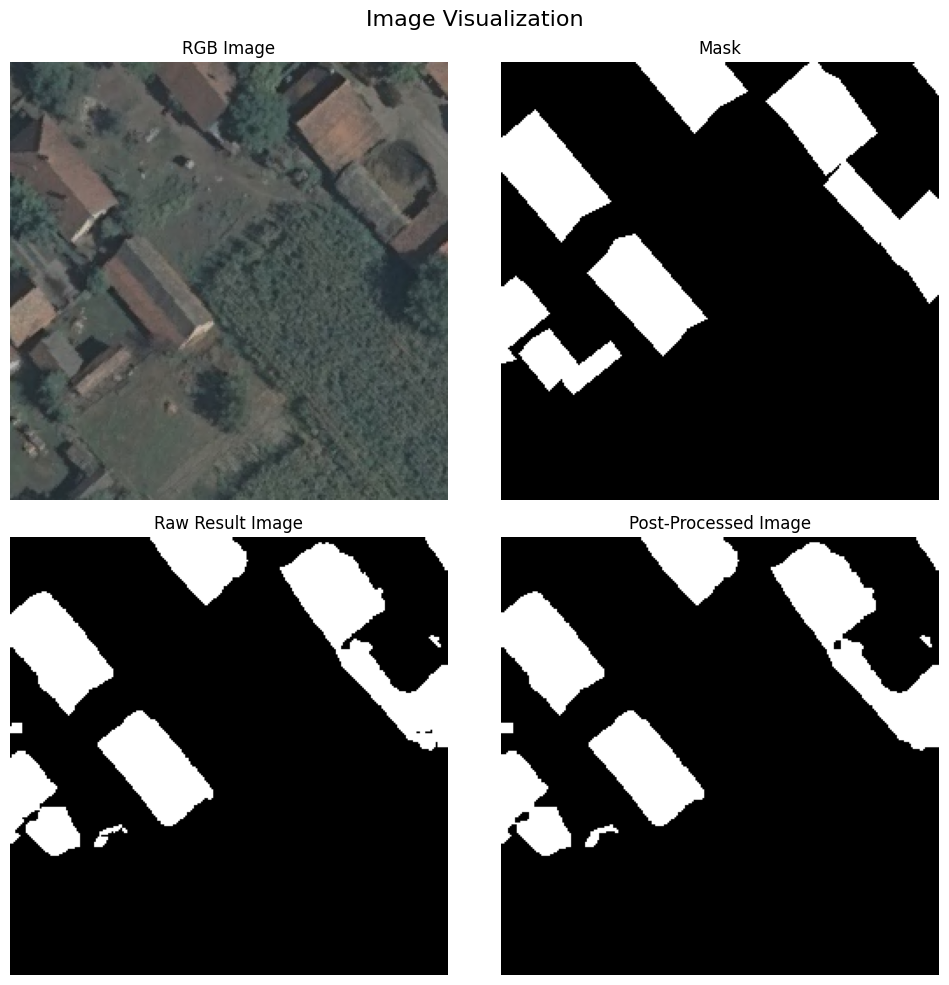

In [13]:
example_image_name = image_files[0] 

# Paths for images
rgb_image_path = os.path.join(RGB_DIR, example_image_name)
mask_image_path = os.path.join(MASK_DIR, example_image_name)
raw_result_image_path = os.path.join(RESULT_IMAGES_DIR, example_image_name)
post_processed_image_path = os.path.join(POST_PROCESS_DIR, example_image_name)

# Loading images
rgb_image = Image.open(rgb_image_path).convert("RGB")
mask_image = Image.open(mask_image_path).convert("L")
raw_result_image = Image.open(raw_result_image_path).convert("L")
post_processed_image = Image.open(post_processed_image_path).convert("L")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(rgb_image)
axes[0, 0].set_title("RGB Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(mask_image, cmap='gray')
axes[0, 1].set_title("Mask")
axes[0, 1].axis('off')

axes[1, 0].imshow(raw_result_image, cmap='gray')
axes[1, 0].set_title("Raw Result Image")
axes[1, 0].axis('off')

axes[1, 1].imshow(post_processed_image, cmap='gray')
axes[1, 1].set_title("Post-Processed Image")
axes[1, 1].axis('off')

fig.suptitle("Image Visualization", fontsize=16)

plt.tight_layout()
plt.show()

### Roofs and solar panels estimation

In [14]:
# DataFrame to store results
df_columns = [
    "Image name",
    "IoU - raw result [%]",
    "IoU - post-processed result [%]",
    "Objects (> 1% total area)",
    "Roof area [m^2] - mapped",
    "Roof area [m^2] - raw result",
    "Roof area [m^2] - post-processed result",
    "Solar panels estimation - mapped",
    "Solar panels estimation - raw result",
    "Solar panels estimation - post-processed result"
]
results_df = pd.DataFrame(columns=df_columns)

print(DOUBLE_LINE)
print("Roofs and solar panels estimation for results")
print(DOUBLE_LINE)

for image_name in tqdm(image_files, desc="Processing images"):
    # Paths for images
    mask_image_path = os.path.join(MASK_DIR, image_name)
    raw_result_image_path = os.path.join(RESULT_IMAGES_DIR, image_name)
    post_processed_image_path = os.path.join(POST_PROCESS_DIR, image_name)

    # Calculate IoU for raw and post-processed results
    iou_raw = calculate_iou(mask_image_path, raw_result_image_path)
    iou_post_processed = calculate_iou(mask_image_path, post_processed_image_path)

    # Calculate for mask
    large_objects_count = count_large_objects(mask_image_path, percentage_threshold=1)
    mask_areas = find_largest_objects_areas(mask_image_path, N=large_objects_count, square_pixel_area=SQUARE_PIXEL_AREA)
    mask_roof_areas = [roof_area_calculation(area) for area in mask_areas]
    mask_solar_panels = sum([solar_panels_estimation(roof_area, SOLAR_PANEL_AREA) for roof_area in mask_roof_areas])
    
    # Calculate for raw result image using N from mask
    raw_areas = find_largest_objects_areas(raw_result_image_path, N=large_objects_count, square_pixel_area=SQUARE_PIXEL_AREA)
    raw_roof_areas = [roof_area_calculation(area) for area in raw_areas]
    raw_solar_panels = sum([solar_panels_estimation(roof_area, SOLAR_PANEL_AREA) for roof_area in raw_roof_areas])
    
    # Calculate for post-processed result image using N from mask
    post_processed_areas = find_largest_objects_areas(post_processed_image_path, N=large_objects_count, square_pixel_area=SQUARE_PIXEL_AREA)
    post_processed_roof_areas = [roof_area_calculation(area) for area in post_processed_areas]
    post_processed_solar_panels = sum([solar_panels_estimation(roof_area, SOLAR_PANEL_AREA) for roof_area in post_processed_roof_areas])
    
    # Append results to DataFrame
    new_row = pd.DataFrame([{
        "Image name": image_name,
        "IoU - raw result [%]": iou_raw,
        "IoU - post-processed result [%]": iou_post_processed,
        "Objects (> 1% total area)": large_objects_count,
        "Roof area [m^2] - mapped": sum(mask_roof_areas),
        "Roof area [m^2] - raw result": sum(raw_roof_areas),
        "Roof area [m^2] - post-processed result": sum(post_processed_roof_areas),
        "Solar panels estimation - mapped": mask_solar_panels,
        "Solar panels estimation - raw result": raw_solar_panels,
        "Solar panels estimation - post-processed result": post_processed_solar_panels
    }])
    
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Save the dataframe
results_df.to_csv(RESULTS_DATAFRAME_PATH, index=False)

print(DOUBLE_LINE)
print(f"Results saved to {RESULTS_DATAFRAME_PATH}")
print(DOUBLE_LINE)

Roofs and solar panels estimation for results


Processing images: 100%|██████████| 150/150 [00:01<00:00, 81.32it/s] 


Results saved to results.csv


### Results view

In [16]:
results_df.head(10)

,Image name,IoU - raw result [%],IoU - post-processed result [%],Objects (> 1% total area),Roof area [m^2] - mapped,Roof area [m^2] - raw result,Roof area [m^2] - post-processed result,Solar panels estimation - mapped,Solar panels estimation - raw result,Solar panels estimation - post-processed result
0,patch_32_94.png,86.37,86.46,6,3323.97,3038.29,3070.49,1847,1689,1706
1,patch_48_74.png,77.81,78.53,1,261.10,202.94,205.25,145,113,114
2,patch_24_5.png,78.33,78.02,1,477.03,495.37,519.18,265,275,288
3,patch_5_83.png,93.71,93.71,1,582.68,593.08,593.08,324,329,329
4,patch_17_52.png,76.22,76.13,3,1147.06,1394.59,1401.07,636,775,779
5,patch_16_2.png,38.19,37.96,0,0.00,0.00,0.00,0,0,0
6,patch_69_21.png,86.90,87.00,1,906.88,865.45,866.60,504,481,481
7,patch_21_97.png,56.18,56.67,1,298.20,213.91,216.51,166,119,120
8,patch_49_8.png,78.95,79.12,2,1020.48,956.67,957.82,567,532,532
9,patch_34_6.png,58.70,58.27,0,0.00,0.00,0.00,0,0,0


### Results statistics

In [15]:
results_df.describe()

,IoU - raw result [%],IoU - post-processed result [%],Roof area [m^2] - mapped,Roof area [m^2] - raw result,Roof area [m^2] - post-processed result
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,70.210667,70.344400,974.113933,899.693400,905.412067
std,21.640846,21.587289,926.899673,881.027963,884.884900
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,64.587500,64.652500,315.195000,252.375000,259.632500
50%,76.570000,76.845000,673.915000,603.760000,604.335000
75%,84.067500,84.077500,1516.557500,1430.822500,1433.127500
max,94.790000,94.900000,5465.920000,5248.850000,5260.810000
